# **Outlier Detection**

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Read the dataset from a CSV file
cyclists_df = pd.read_csv('../dataset/cyclists_clustering.csv')
races_df = pd.read_csv('../dataset/races_clustering.csv')

cyclists_with_outlier_score = cyclists_df.copy()

cyclists_df = cyclists_df.select_dtypes(include=[np.number])

races_with_outlier_score = races_df.copy()

scaler = MinMaxScaler()
cyclists_df = pd.DataFrame(scaler.fit_transform(cyclists_df), columns=cyclists_df.columns)



cyclist_numeric_columns = cyclists_df.columns.to_list()
races_numeric_columns = races_df.columns.to_list()

cyclists_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4311 entries, 0 to 4310
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   birth_year          4311 non-null   float64
 1   cyclist_experience  4311 non-null   float64
 2   cyclist_win         4311 non-null   float64
 3   weighted_podiums    4311 non-null   float64
 4   career_level        4311 non-null   float64
 5   avg_position        4311 non-null   float64
 6   best_position       4311 non-null   float64
 7   best_position_std   4311 non-null   float64
dtypes: float64(8)
memory usage: 269.6 KB


## Connectivity approach


In [25]:
from sklearn.neighbors import LocalOutlierFactor

k = 15

algorithm = LocalOutlierFactor(n_neighbors=k)
algorithm.fit(cyclists_df)

# negated outlier scores: the higher, the more of an outlier
outlier_degrees = - algorithm.negative_outlier_factor_
cyclists_with_outlier_score.loc[:, "lof_degree"] = outlier_degrees

Plot the lof degree to understand where to put a threshold

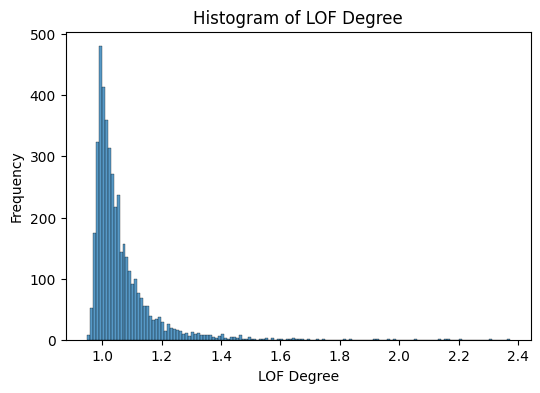

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))  # Set the figure size
sns.histplot(outlier_degrees, binwidth=0.01)
plt.xlabel('LOF Degree')
plt.ylabel('Frequency')
plt.title('Histogram of LOF Degree')
plt.show()

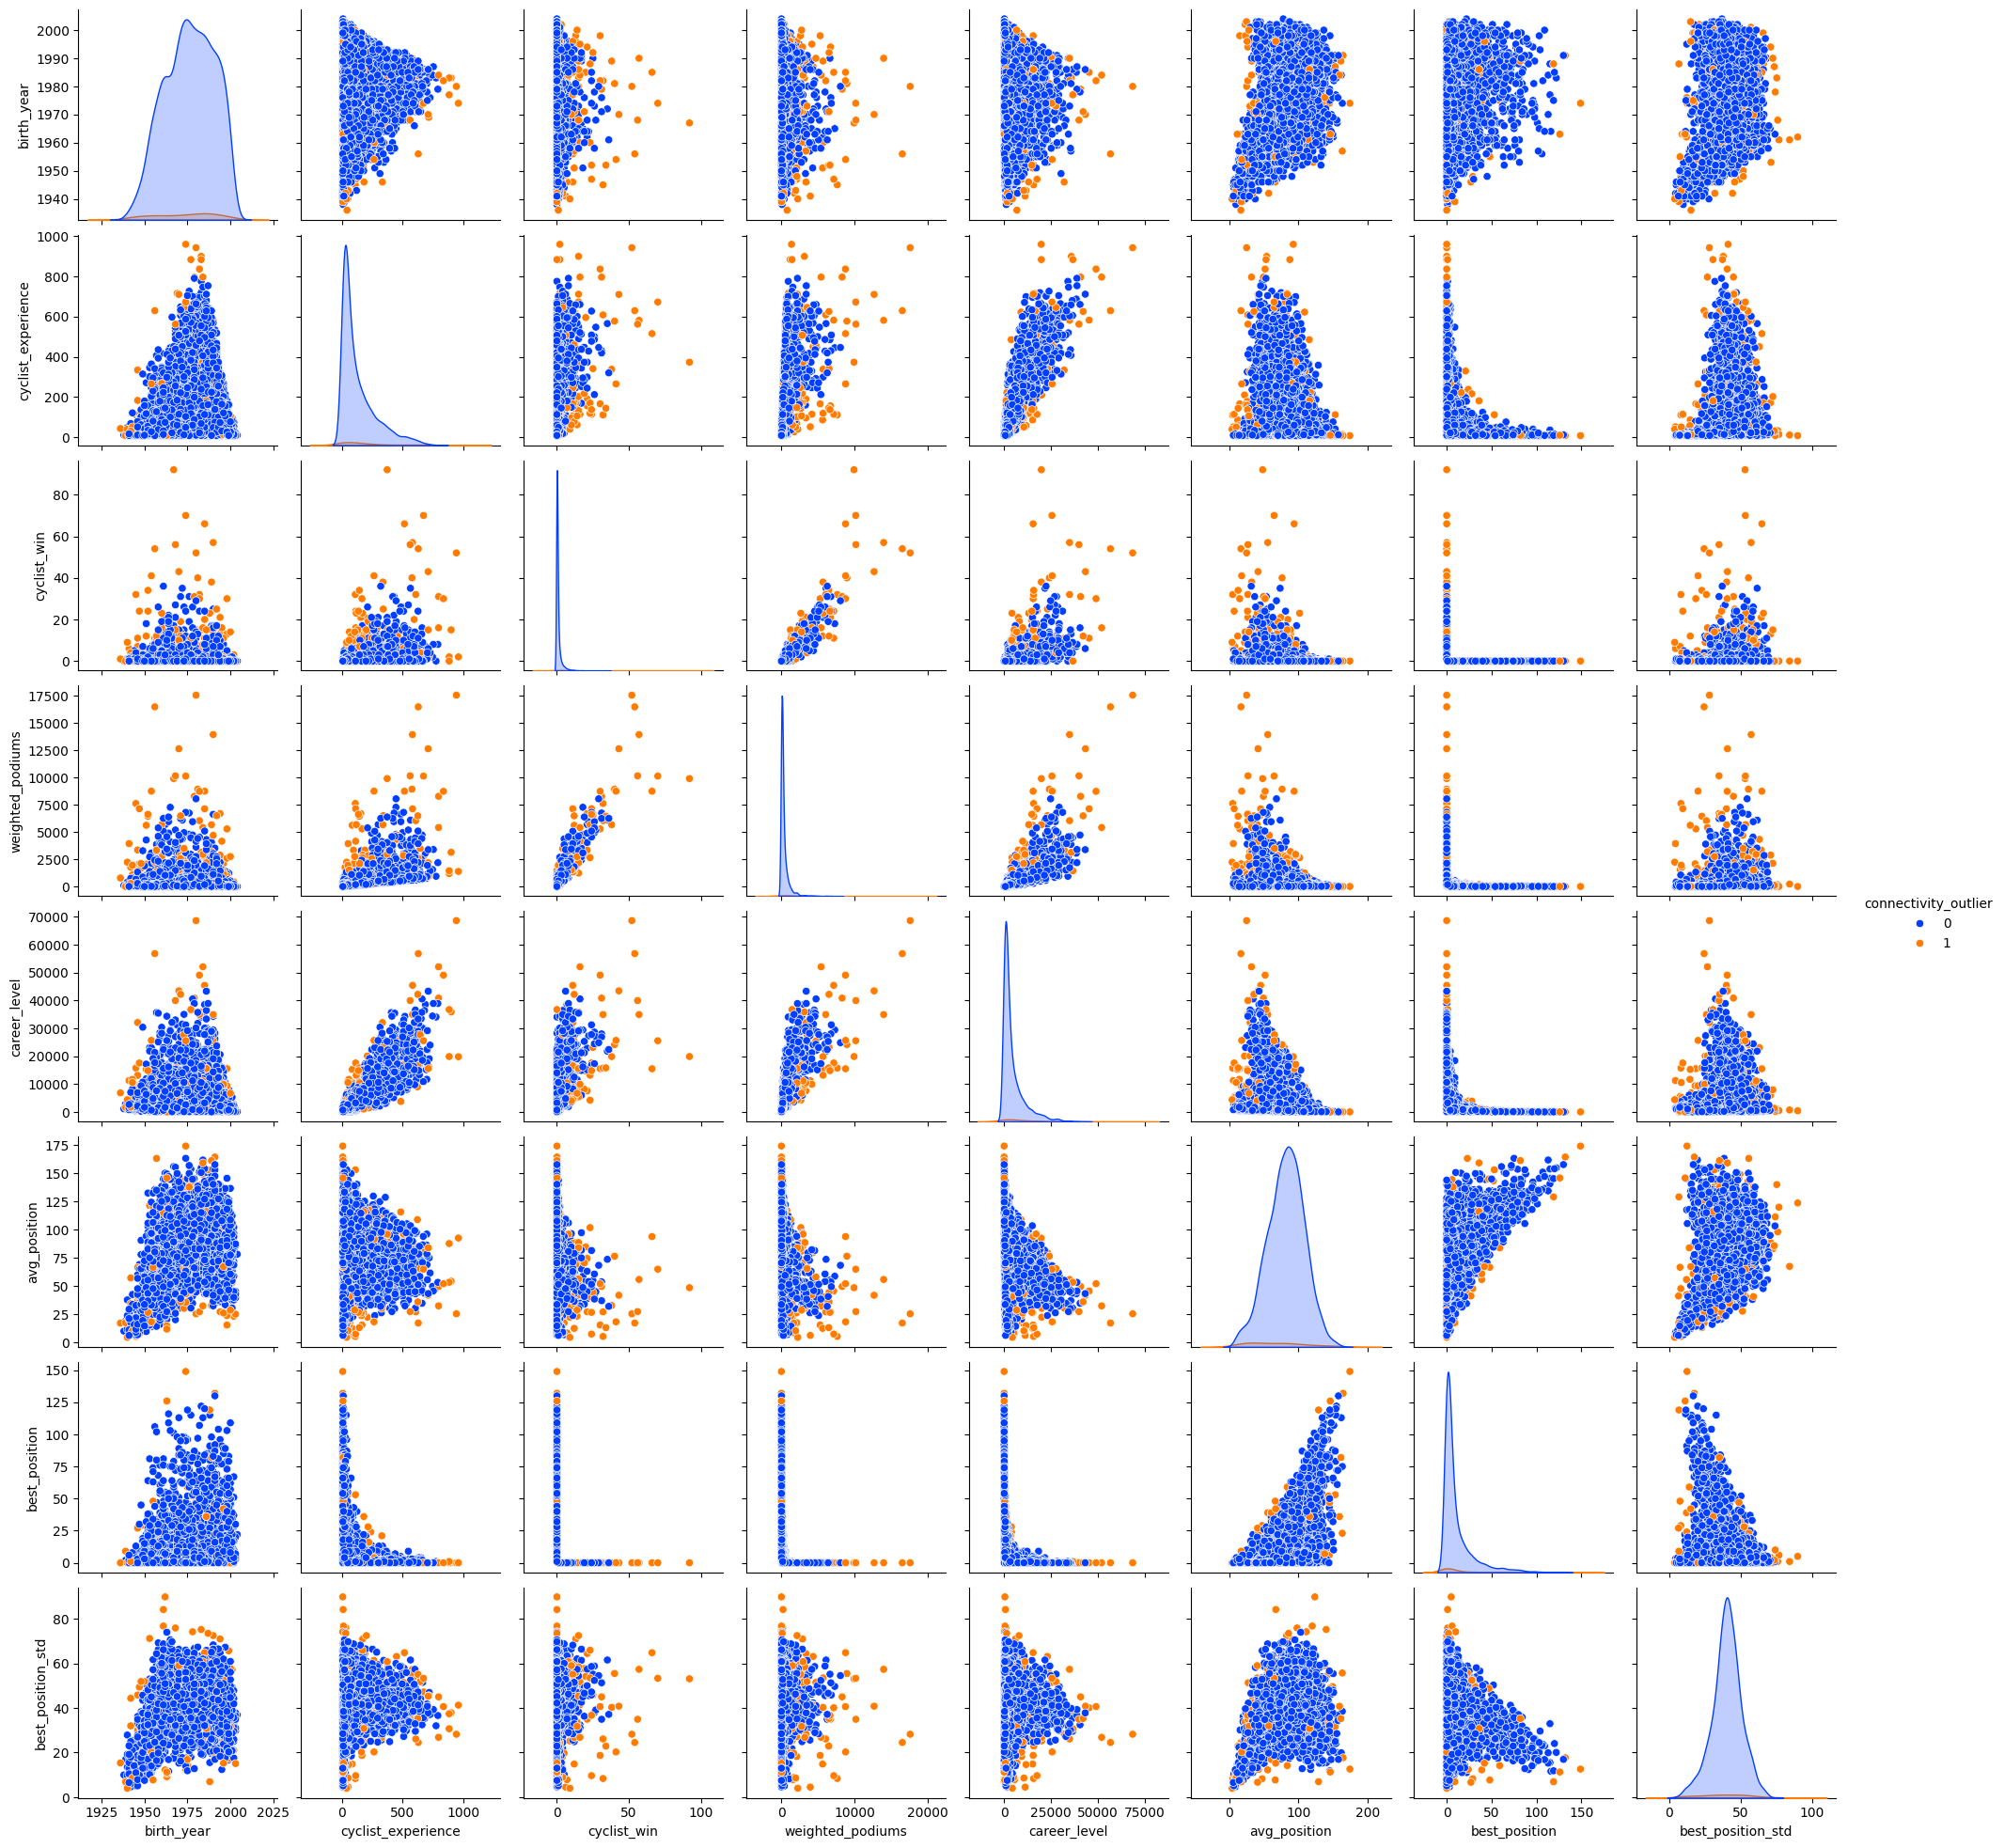

In [27]:

threshold = 1.3 # 1.4 for less outliers

# Threshold and map to {0: inlier, 1: outlier}
cyclists_with_outlier_score['connectivity_outlier'] = (cyclists_with_outlier_score['lof_degree'] > threshold).astype(int)

sns.pairplot(cyclists_with_outlier_score[cyclist_numeric_columns + ['connectivity_outlier']], hue='connectivity_outlier', diag_kind='kde', palette='bright')
plt.show()

Counting outliers identified

In [28]:
cyclists_with_outlier_score["connectivity_outlier"].value_counts()

connectivity_outlier
0    4152
1     159
Name: count, dtype: int64

Analyze some of them

In [29]:
outliers = cyclists_with_outlier_score[cyclists_with_outlier_score['connectivity_outlier'] == 1]
print(outliers.drop(columns="connectivity_outlier").head())

                   _url              name  birth_year  nationality  \
5      joost-van-leijen  Joost van Leijen        1984  Netherlands   
29         mario-scirea     Mario  Scirea        1964        Italy   
63  juan-ayuso-pesquera       Juan  Ayuso        2002        Spain   
64         jorge-azanza     Jorge  Azanza        1982        Spain   
80        tadej-pogacar    Tadej  Pogačar        1998     Slovenia   

    cyclist_experience experience_cat continent  cyclist_win  \
5                   29   Intermediate    Europe            0   
29                 435         Expert    Europe            0   
63                  53   Intermediate    Europe            3   
64                 238         Expert    Europe            0   
80                 166       Advanced    Europe           30   

    weighted_podiums  career_level  avg_position  best_position  \
5               29.0        248.00    149.137931             36   
29             571.0       8918.90     96.275862            

## One-class SVM


In [30]:
from sklearn.svm import OneClassSVM


kernel = "rbf"      # "linear", "poly", "rbf", "sigmoid"
algorithm = OneClassSVM(kernel=kernel, nu=0.05) #0.04 for less outliers
algorithm.fit(cyclists_df)

# this implementation provides two different scores:
#   outlier classification in {+1, -1}
#   outlier scores in R: distance from hyperplane
outlier_classification_scores = algorithm.predict(cyclists_df)

outlier_distance_scores = algorithm.score_samples(cyclists_df)

cyclists_with_outlier_score.loc[:, "svm_degree"] = outlier_distance_scores
# map to {0: inliers, : outliers}
cyclists_with_outlier_score.loc[:, "svm_outlier"] = -(outlier_classification_scores  - 1) / 2  

print(cyclists_with_outlier_score['svm_outlier'].value_counts())

if kernel == "linear":
    support_vectors = cyclists_df.iloc[algorithm.support_]
    
else:
    support_vectors = None

svm_outlier
0.0    4096
1.0     215
Name: count, dtype: int64


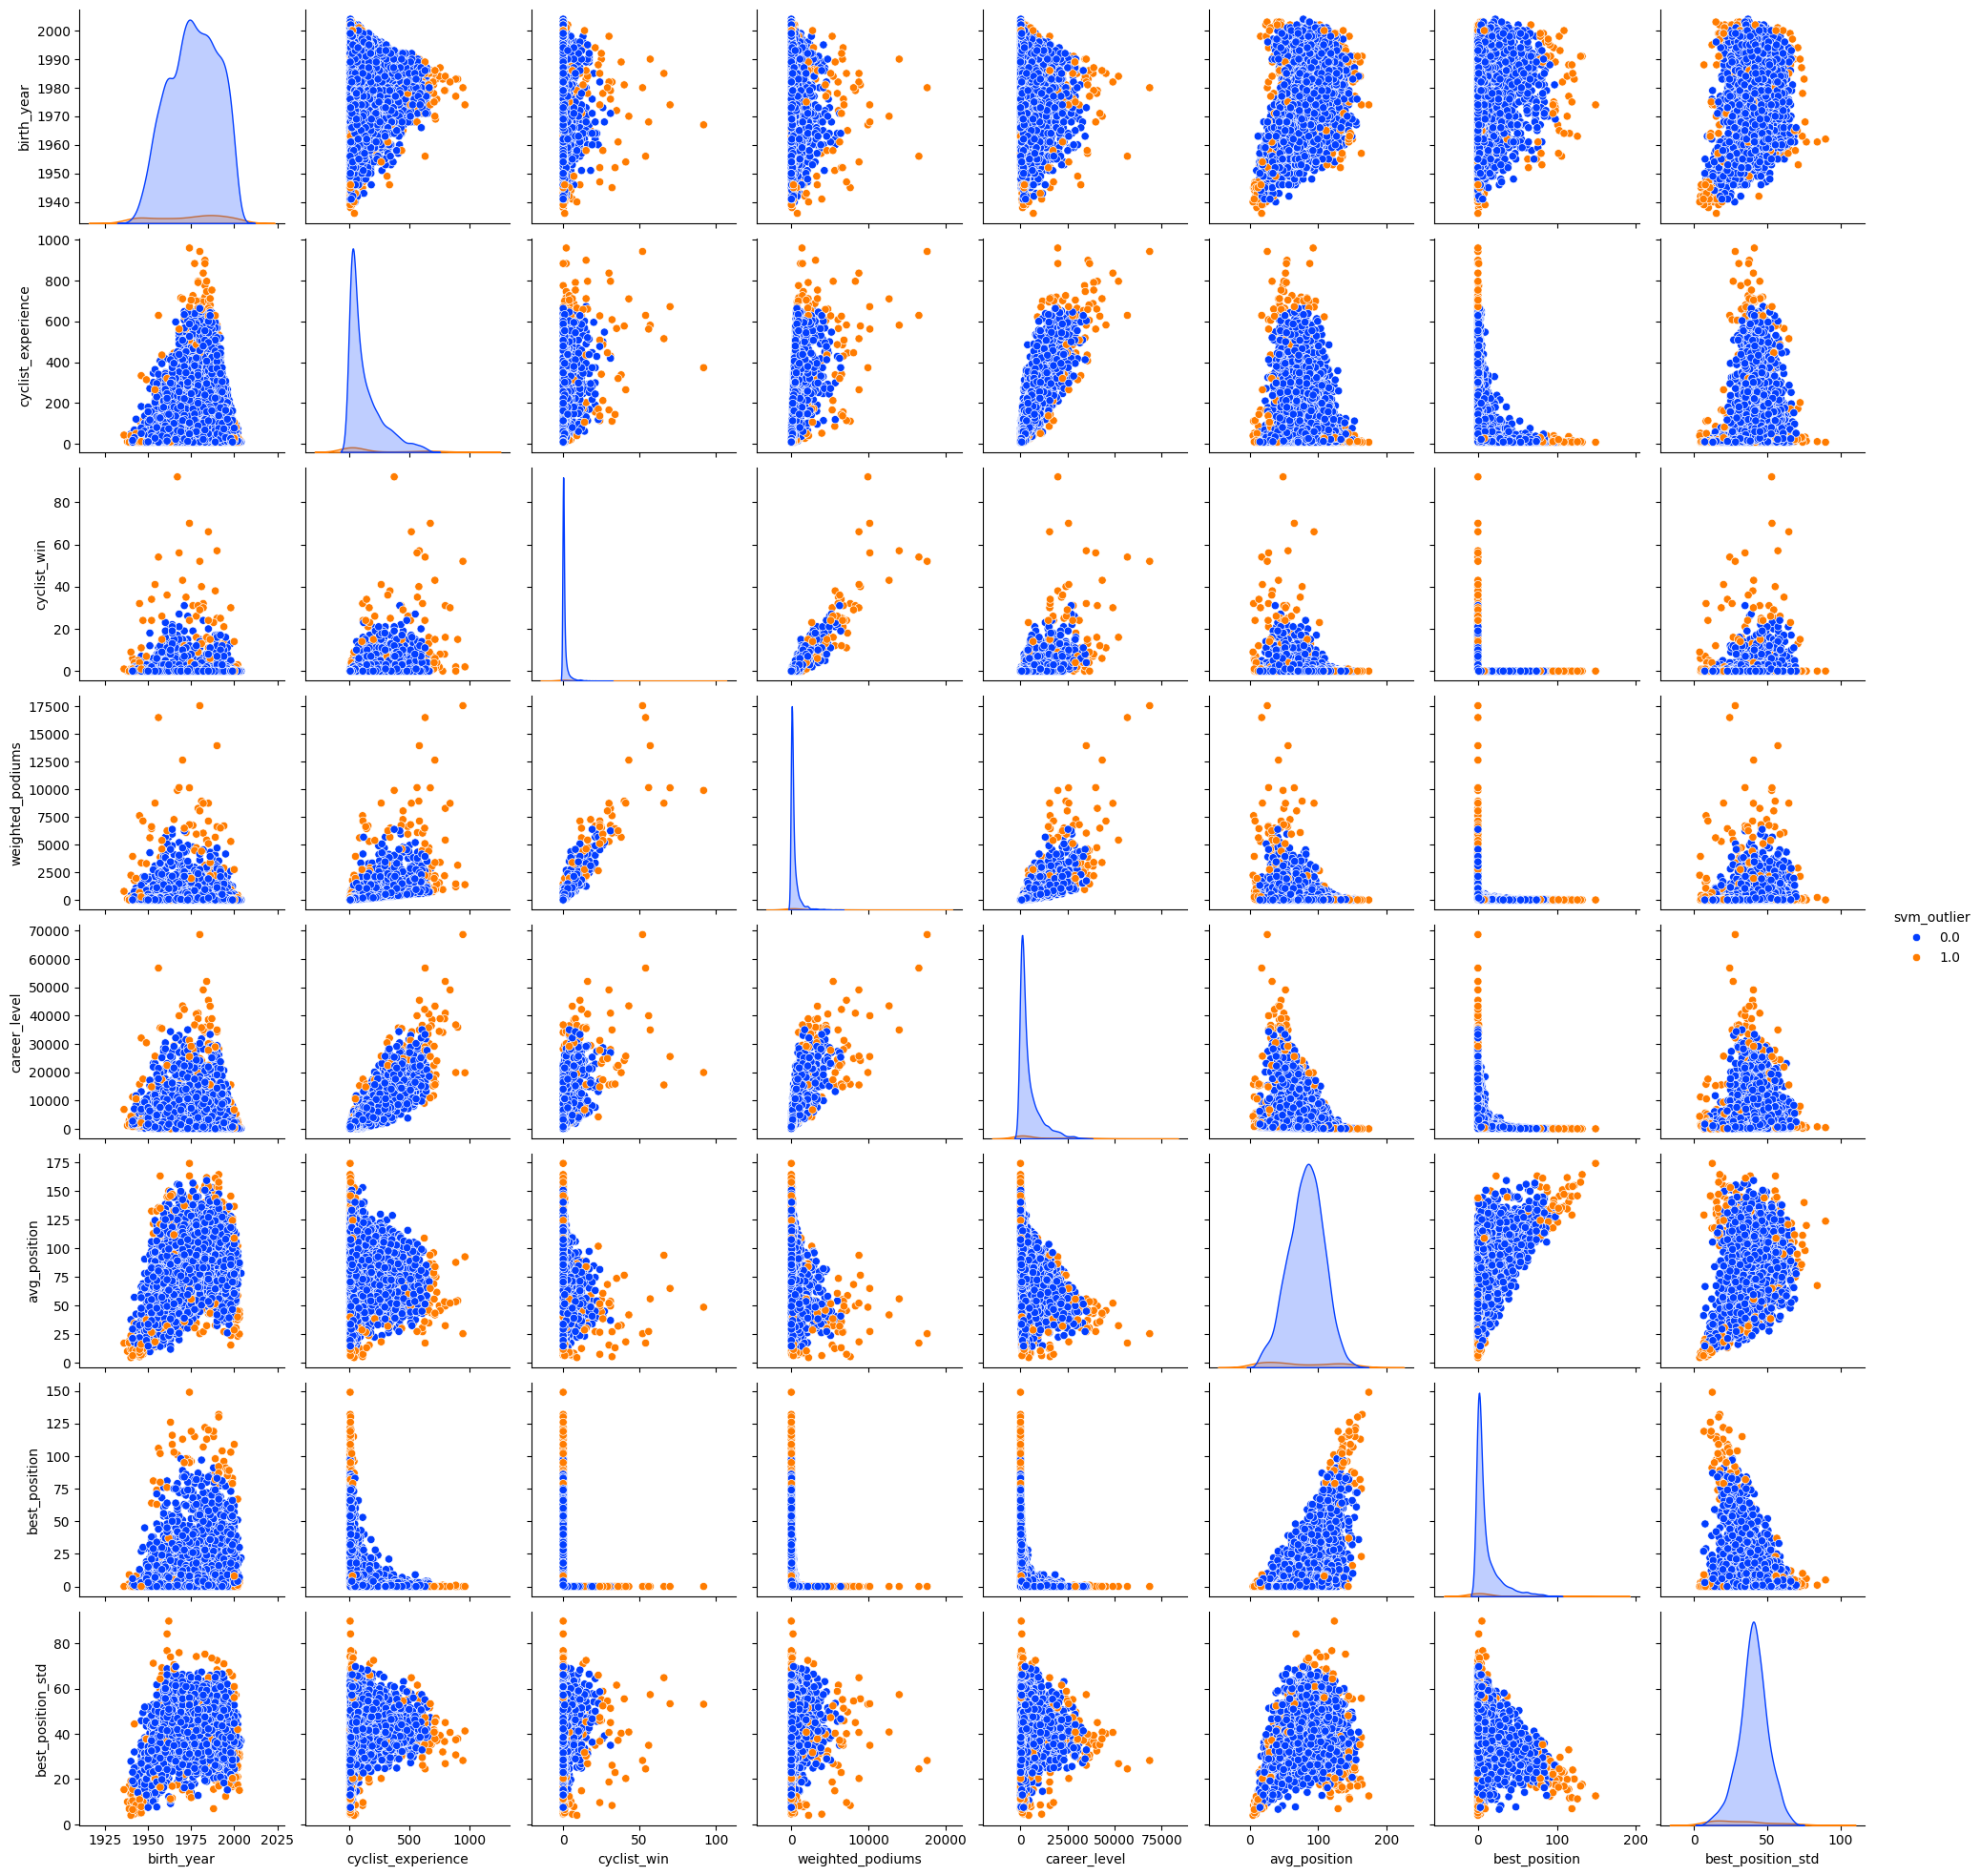

In [31]:
# Classify points as outliers or not

cyclists_with_outlier_score.drop(columns=['svm_degree'], inplace=True)

sns.pairplot(cyclists_with_outlier_score[cyclist_numeric_columns + ["svm_outlier"]], hue='svm_outlier', diag_kind='kde', palette='bright')
plt.show()

In [32]:
cyclists_with_outlier_score["svm_outlier"].value_counts()

svm_outlier
0.0    4096
1.0     215
Name: count, dtype: int64

Analyze some of them

In [33]:
outliers = cyclists_with_outlier_score[cyclists_with_outlier_score['svm_outlier'] == 1]
print(outliers.drop(columns=["svm_outlier"]).head())

                   _url               name  birth_year    nationality  \
46          andrew-fenn       Andrew  Fenn        1990  Great Britain   
54        idar-andersen     Idar  Andersen        1999         Norway   
62     michael-matthews  Michael  Matthews        1990      Australia   
63  juan-ayuso-pesquera        Juan  Ayuso        2002          Spain   
71      manuele-tarozzi   Manuele  Tarozzi        1998          Italy   

    cyclist_experience experience_cat continent  cyclist_win  \
46                  18       Beginner    Europe            0   
54                  14       Beginner    Europe            0   
62                 485         Expert   Oceania           25   
63                  53   Intermediate    Europe            3   
71                   8       Beginner    Europe            0   

    weighted_podiums  career_level  avg_position  best_position  \
46              18.0        381.95    105.500000              5   
54              14.0         22.50    126.

Analyze which cyclists has both outlier score positive

In [34]:
outliers = cyclists_with_outlier_score[(cyclists_with_outlier_score['svm_outlier'] == 1) & (cyclists_with_outlier_score['connectivity_outlier'] == 1)]
print(f"In total there are {int(len(outliers))} data with both outlier scores positive\n")
print(outliers.drop(columns=["svm_outlier", "connectivity_outlier"]).head())


In total there are 68 data with both outlier scores positive

                    _url             name  birth_year  nationality  \
63   juan-ayuso-pesquera      Juan  Ayuso        2002        Spain   
80         tadej-pogacar   Tadej  Pogačar        1998     Slovenia   
201       mattia-gavazzi  Mattia  Gavazzi        1983        Italy   
212       frans-verbeeck  Frans  Verbeeck        1941      Belgium   
279          hans-kanel2      Hans  Känel        1953  Switzerland   

     cyclist_experience experience_cat continent  cyclist_win  \
63                   53   Intermediate    Europe            3   
80                  166       Advanced    Europe           30   
201                  13       Beginner    Europe            0   
212                  52   Intermediate    Europe            6   
279                  18       Beginner    Europe            0   

     weighted_podiums  career_level  avg_position  best_position  \
63              437.0       2865.45     23.094340         

## Isolation forest


In [35]:
from sklearn.ensemble import IsolationForest

# Initialize the Isolation Forest algorithm with a lower contamination value
isolation_forest = IsolationForest(n_estimators=200, contamination=0.04, n_jobs=-1, random_state=42)
isolation_forest.fit(cyclists_df)

# Compute the outlier scores
outlier_scores = isolation_forest.decision_function(cyclists_df)       # negative values are outliers
outlier_predictions = isolation_forest.predict(cyclists_df)

# Add the outlier scores to the dataframe
cyclists_with_outlier_score['isolation_forest_score'] = outlier_scores
cyclists_with_outlier_score['isolation_forest_outlier'] = (outlier_predictions == -1).astype(int)

print(cyclists_with_outlier_score['isolation_forest_outlier'].value_counts())

isolation_forest_outlier
0    4138
1     173
Name: count, dtype: int64


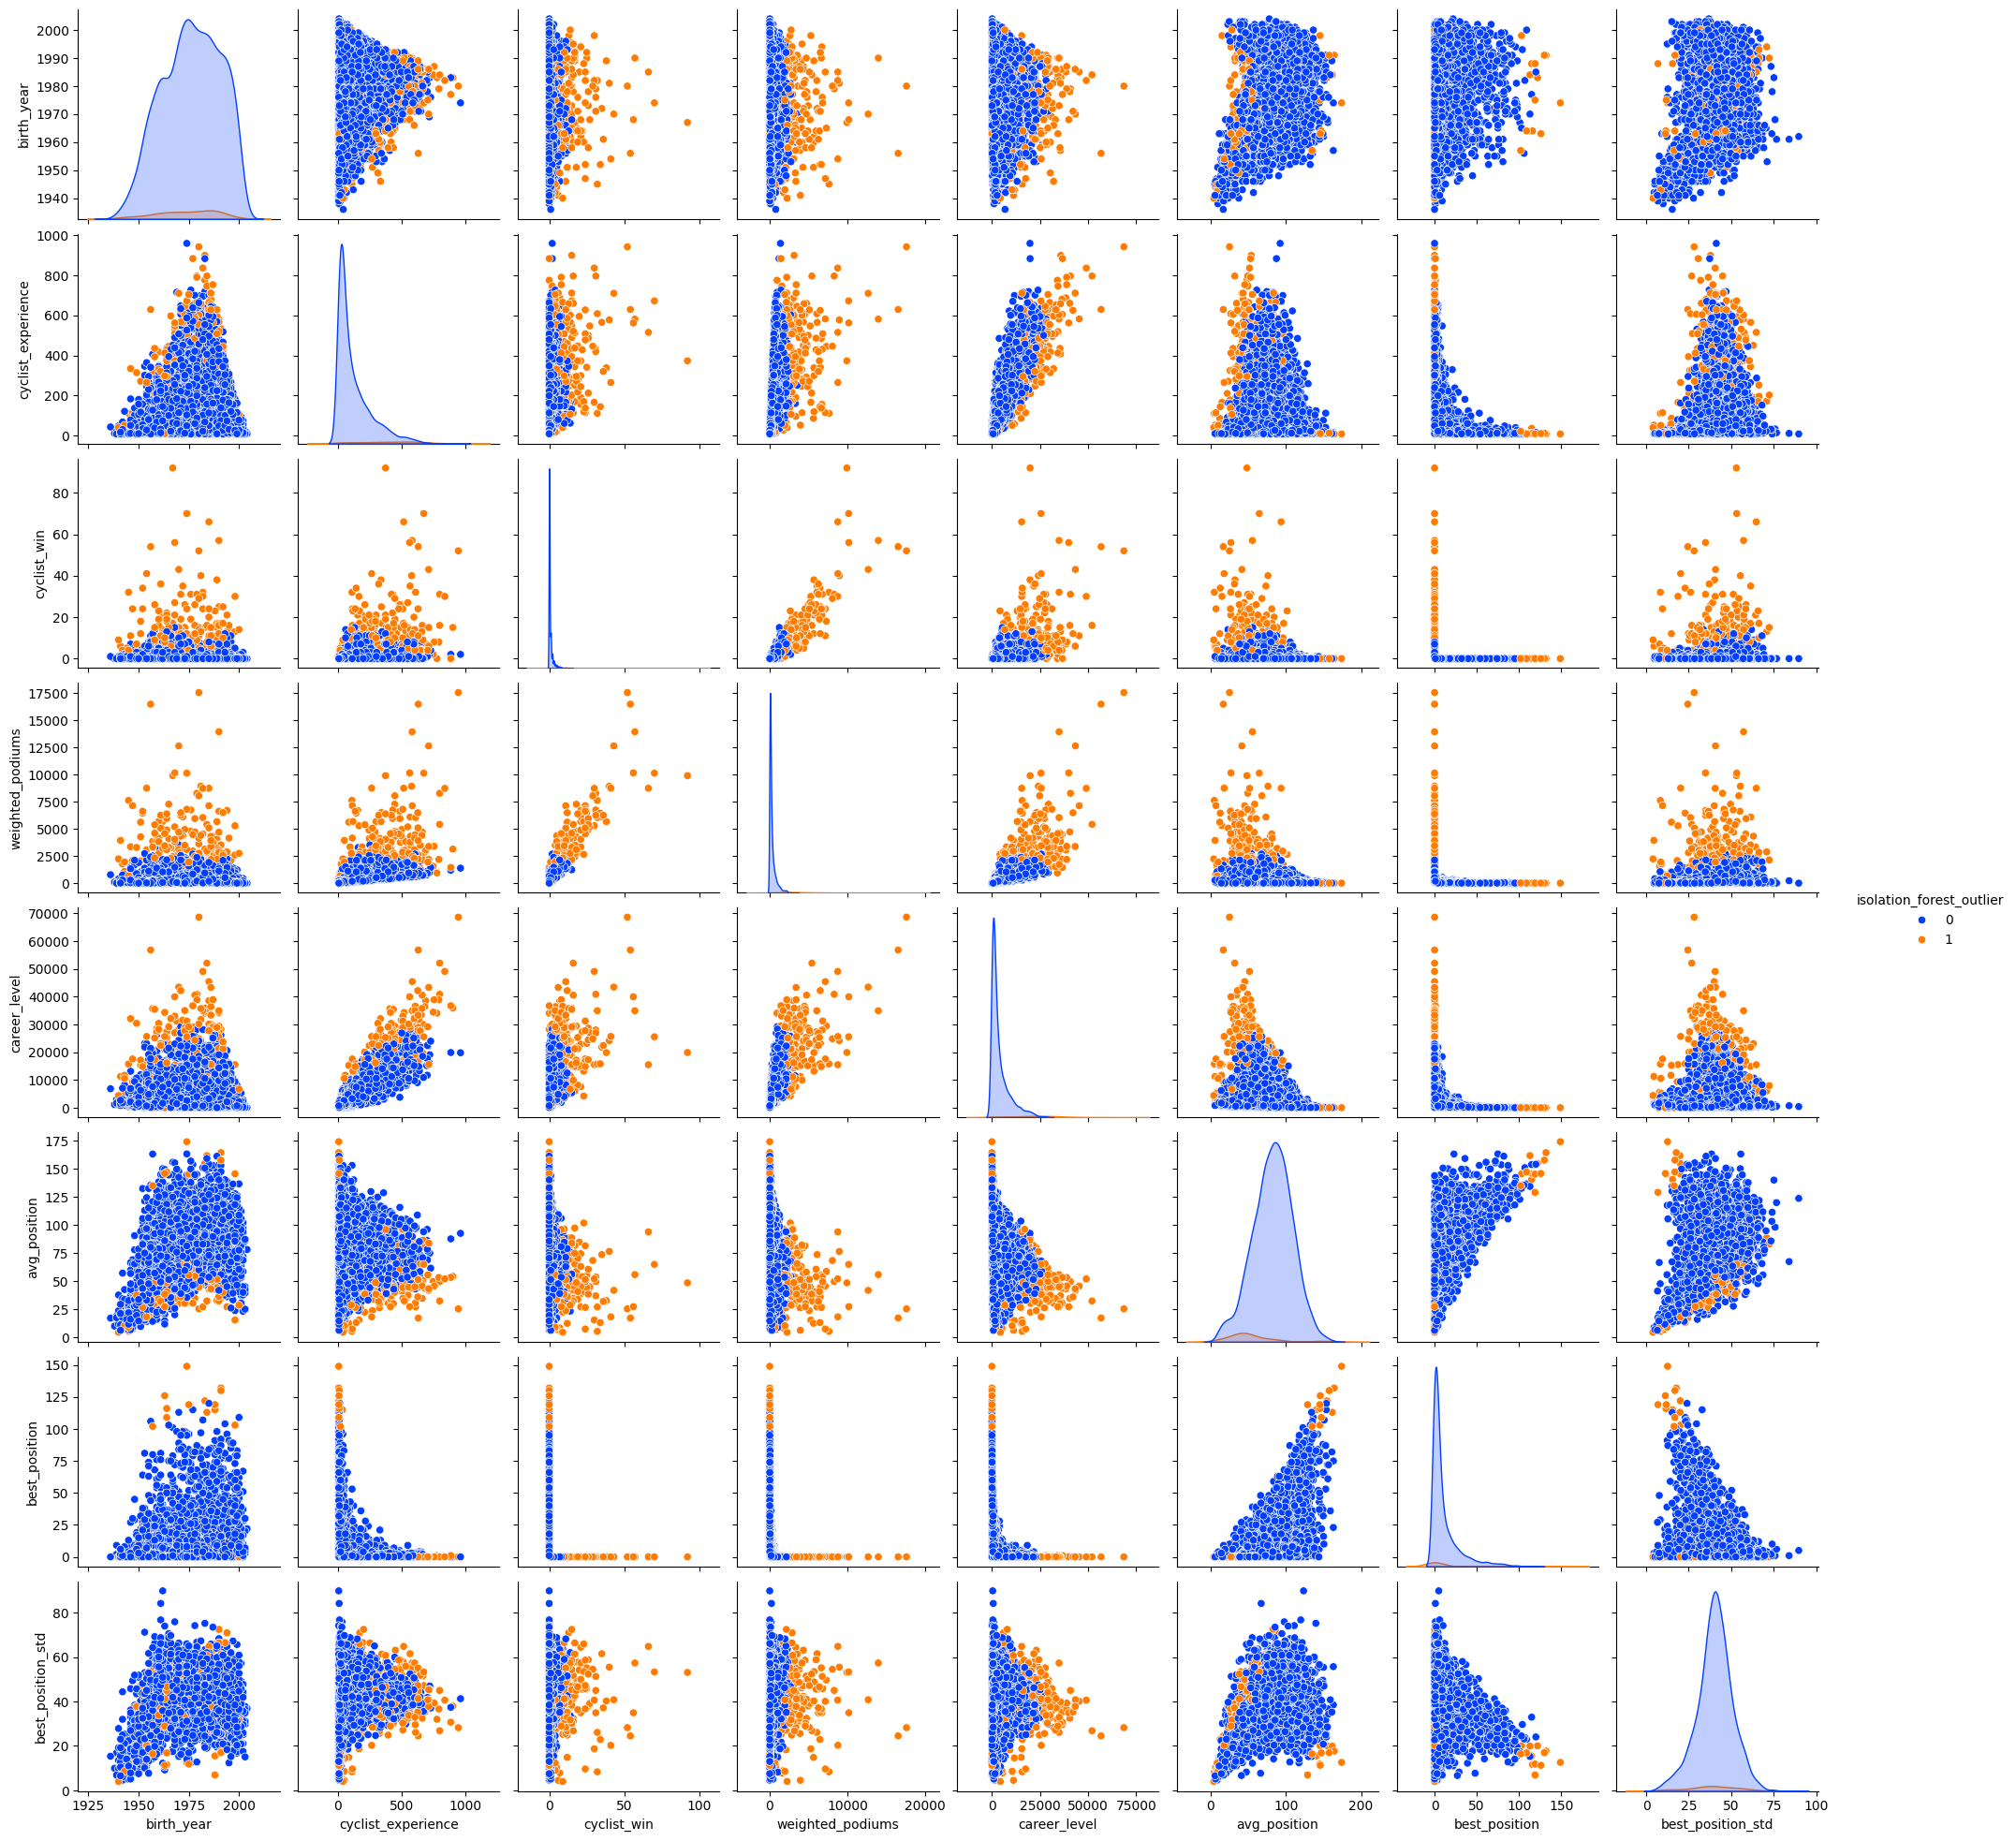

In [36]:
cyclists_with_outlier_score.drop(columns=['isolation_forest_score'], inplace=True)

sns.pairplot(cyclists_with_outlier_score[cyclist_numeric_columns + ["isolation_forest_outlier"]], hue="isolation_forest_outlier", diag_kind='kde', palette='bright')
plt.show()

## ENSAMBLING DECISION

Check when at least two outlier score are positive to classify a point as an outlier

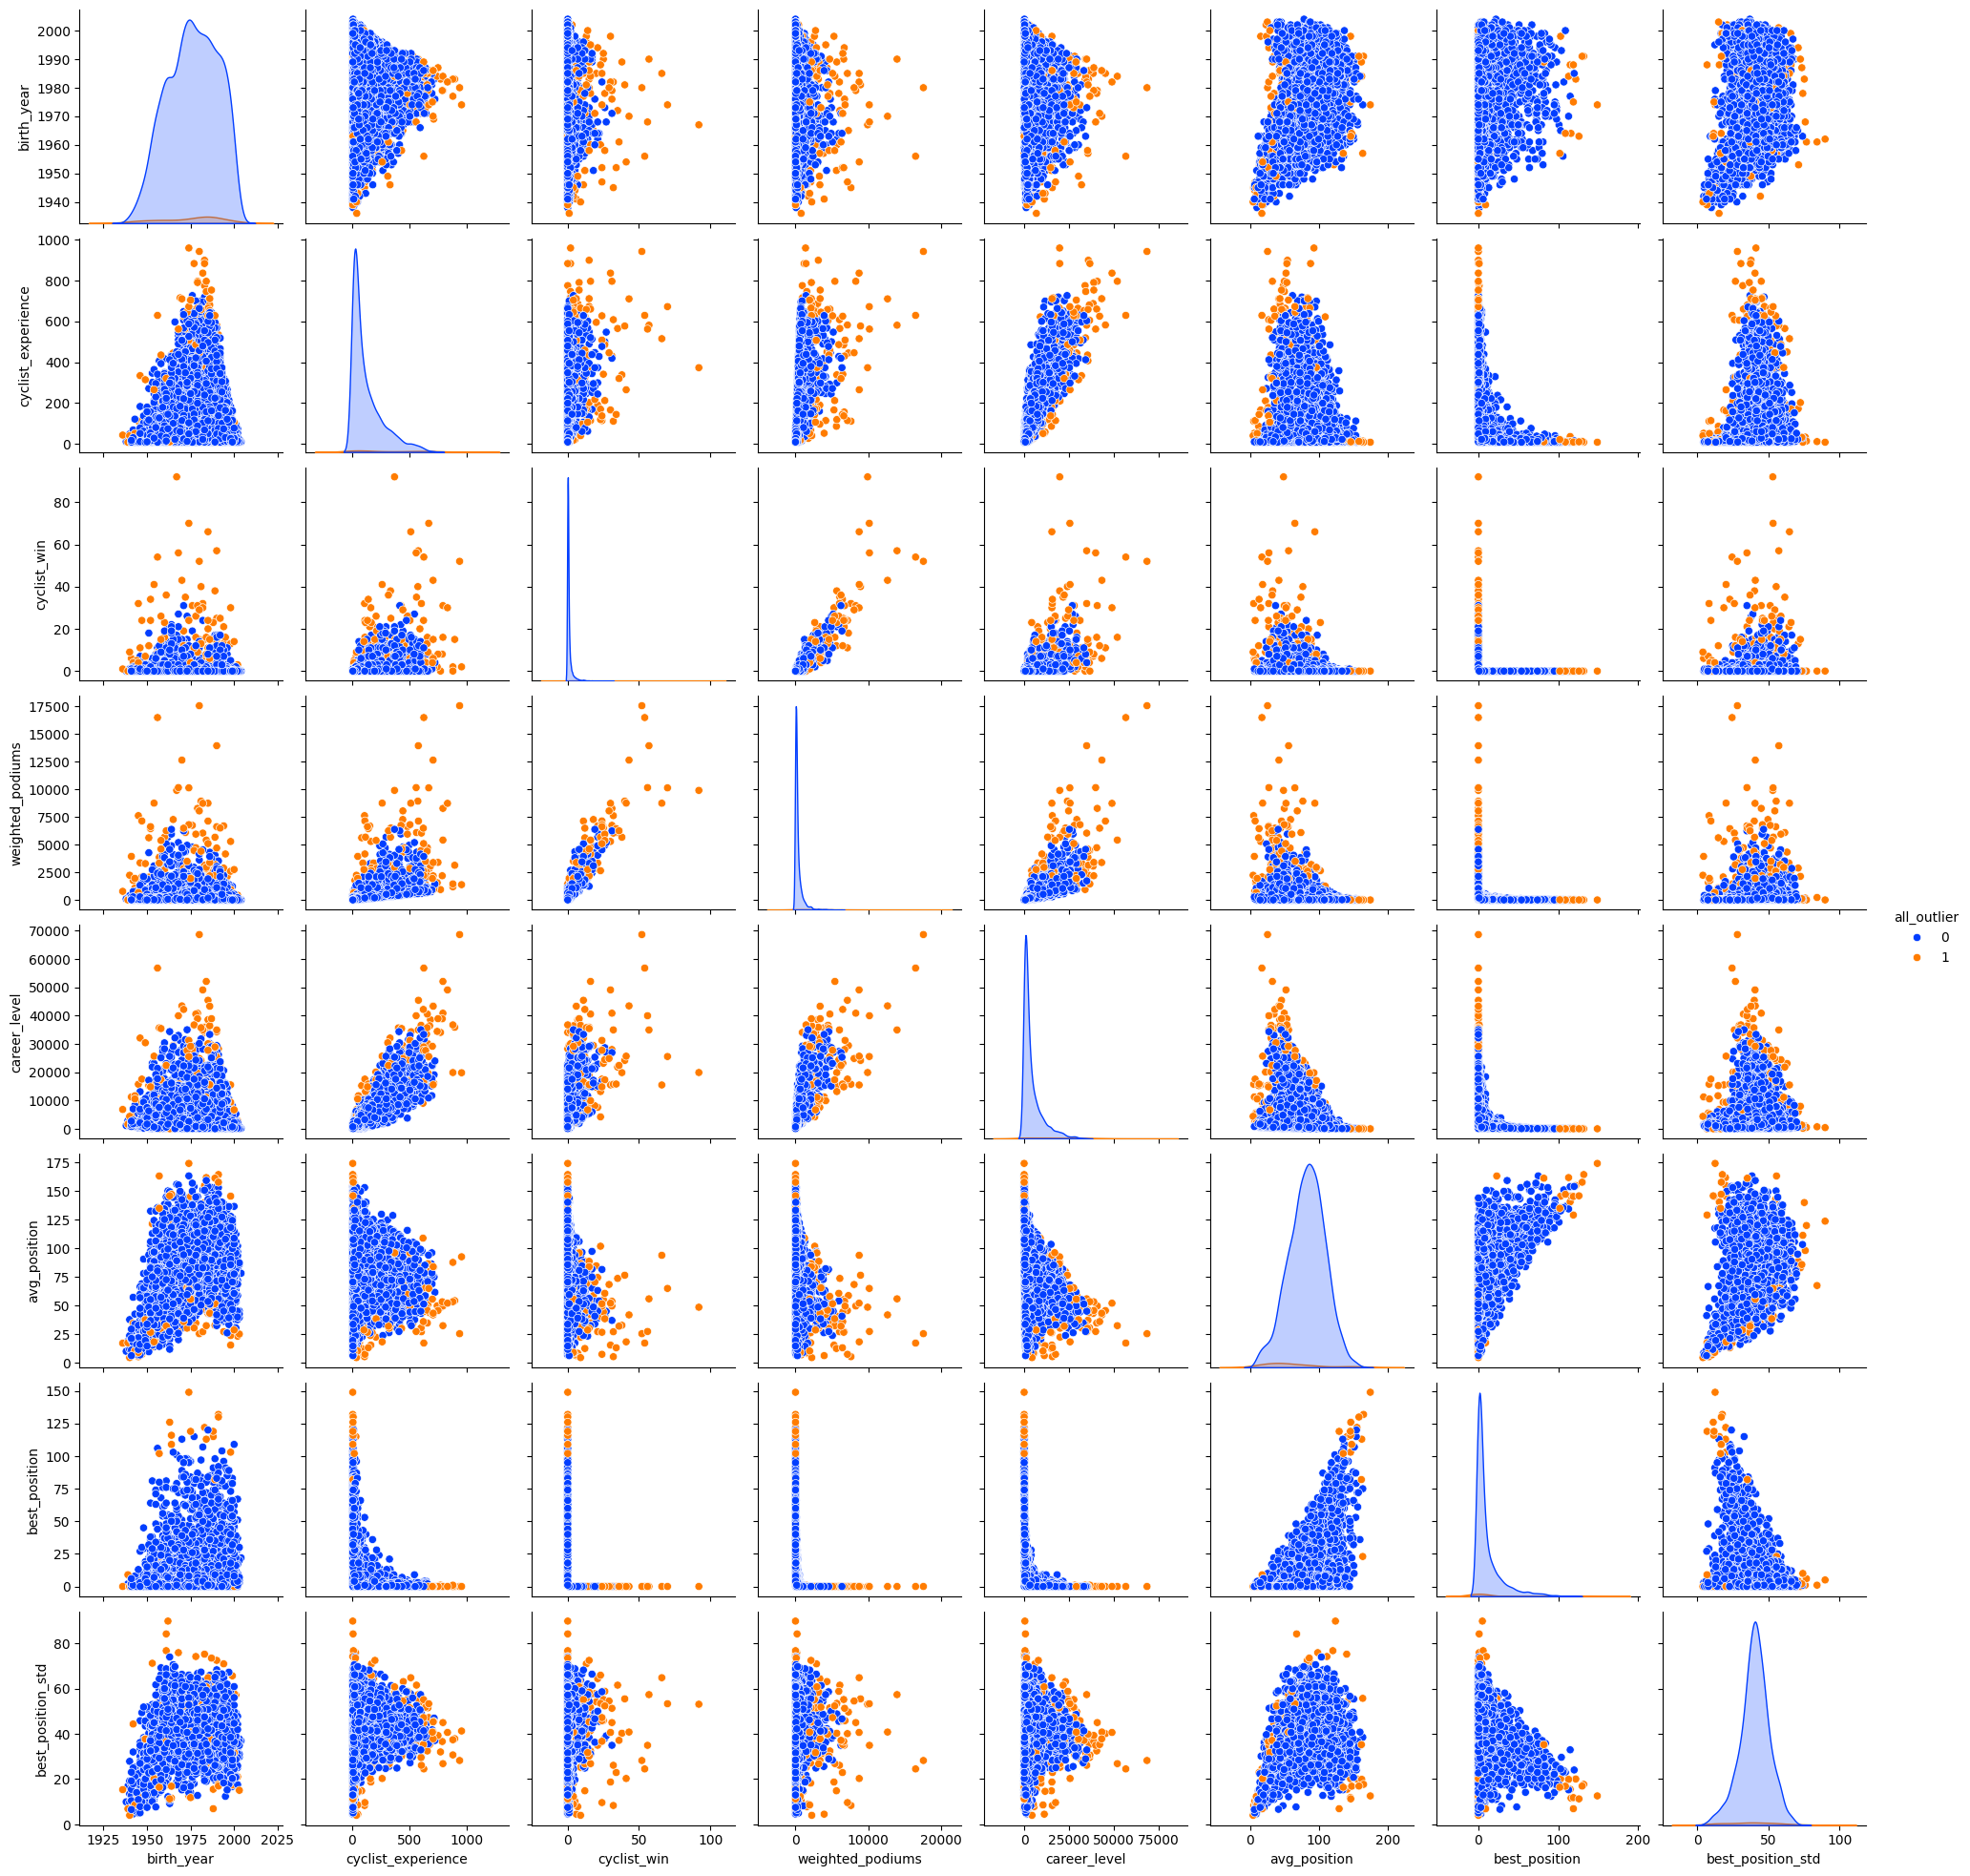

In [37]:
cond1 = (cyclists_with_outlier_score['isolation_forest_outlier'] == 1) & (cyclists_with_outlier_score['svm_outlier'] == 1) 
cond2 = (cyclists_with_outlier_score['isolation_forest_outlier'] == 1) & (cyclists_with_outlier_score['connectivity_outlier'] == 1)
cond3 = (cyclists_with_outlier_score['svm_outlier'] == 1) & (cyclists_with_outlier_score['connectivity_outlier'] == 1)
cond = cond1 | cond2 | cond3

cyclists_with_outlier_score['all_outlier'] = (cond).astype(int)

sns.pairplot(cyclists_with_outlier_score[cyclist_numeric_columns + ["all_outlier"]], hue='all_outlier', diag_kind='kde', palette='bright')
plt.show()

Count how many outliers individued by both methods

In [38]:
print(cyclists_with_outlier_score['all_outlier'].value_counts())

all_outlier
0    4179
1     132
Name: count, dtype: int64


Trying to characterize the outlier

In [39]:
outlier_df = cyclists_with_outlier_score[cyclist_numeric_columns + ['all_outlier']]
outlier_df = outlier_df[outlier_df['all_outlier'] == 1]

# Normalize the data
normalized_outlier_df = pd.DataFrame(scaler.transform(outlier_df[cyclist_numeric_columns]), columns=cyclist_numeric_columns)

print(normalized_outlier_df.describe())

       birth_year  cyclist_experience  cyclist_win  weighted_podiums  \
count  132.000000          132.000000   132.000000        132.000000   
mean     0.562389            0.342144     0.146327          0.193330   
std      0.253916            0.308045     0.180501          0.196037   
min      0.000000            0.000000     0.000000          0.000000   
25%      0.363971            0.031020     0.010870          0.036087   
50%      0.625000            0.283912     0.086957          0.149272   
75%      0.750000            0.646425     0.220109          0.306766   
max      0.985294            1.000000     1.000000          1.000000   

       career_level  avg_position  best_position  best_position_std  
count    132.000000    132.000000     132.000000         132.000000  
mean       0.258663      0.348136       0.089028           0.403959  
std        0.222394      0.254514       0.244239           0.225789  
min        0.000000      0.000000       0.000000           0.000000  
2

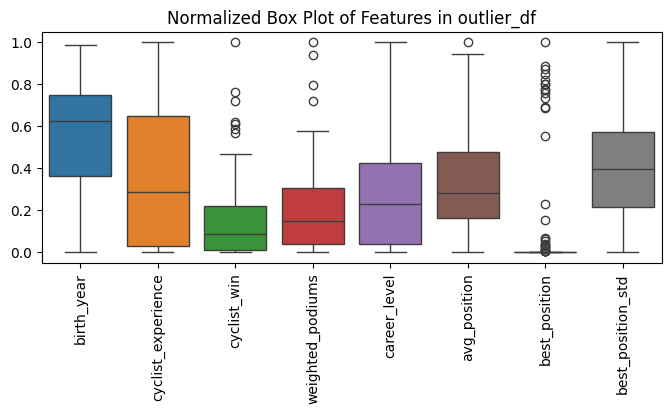

In [40]:
 # Create a box plot
plt.figure(figsize=(8, 3))
sns.boxplot(data=normalized_outlier_df[cyclist_numeric_columns])
plt.xticks(rotation=90)
plt.title('Normalized Box Plot of Features in outlier_df')
plt.show()

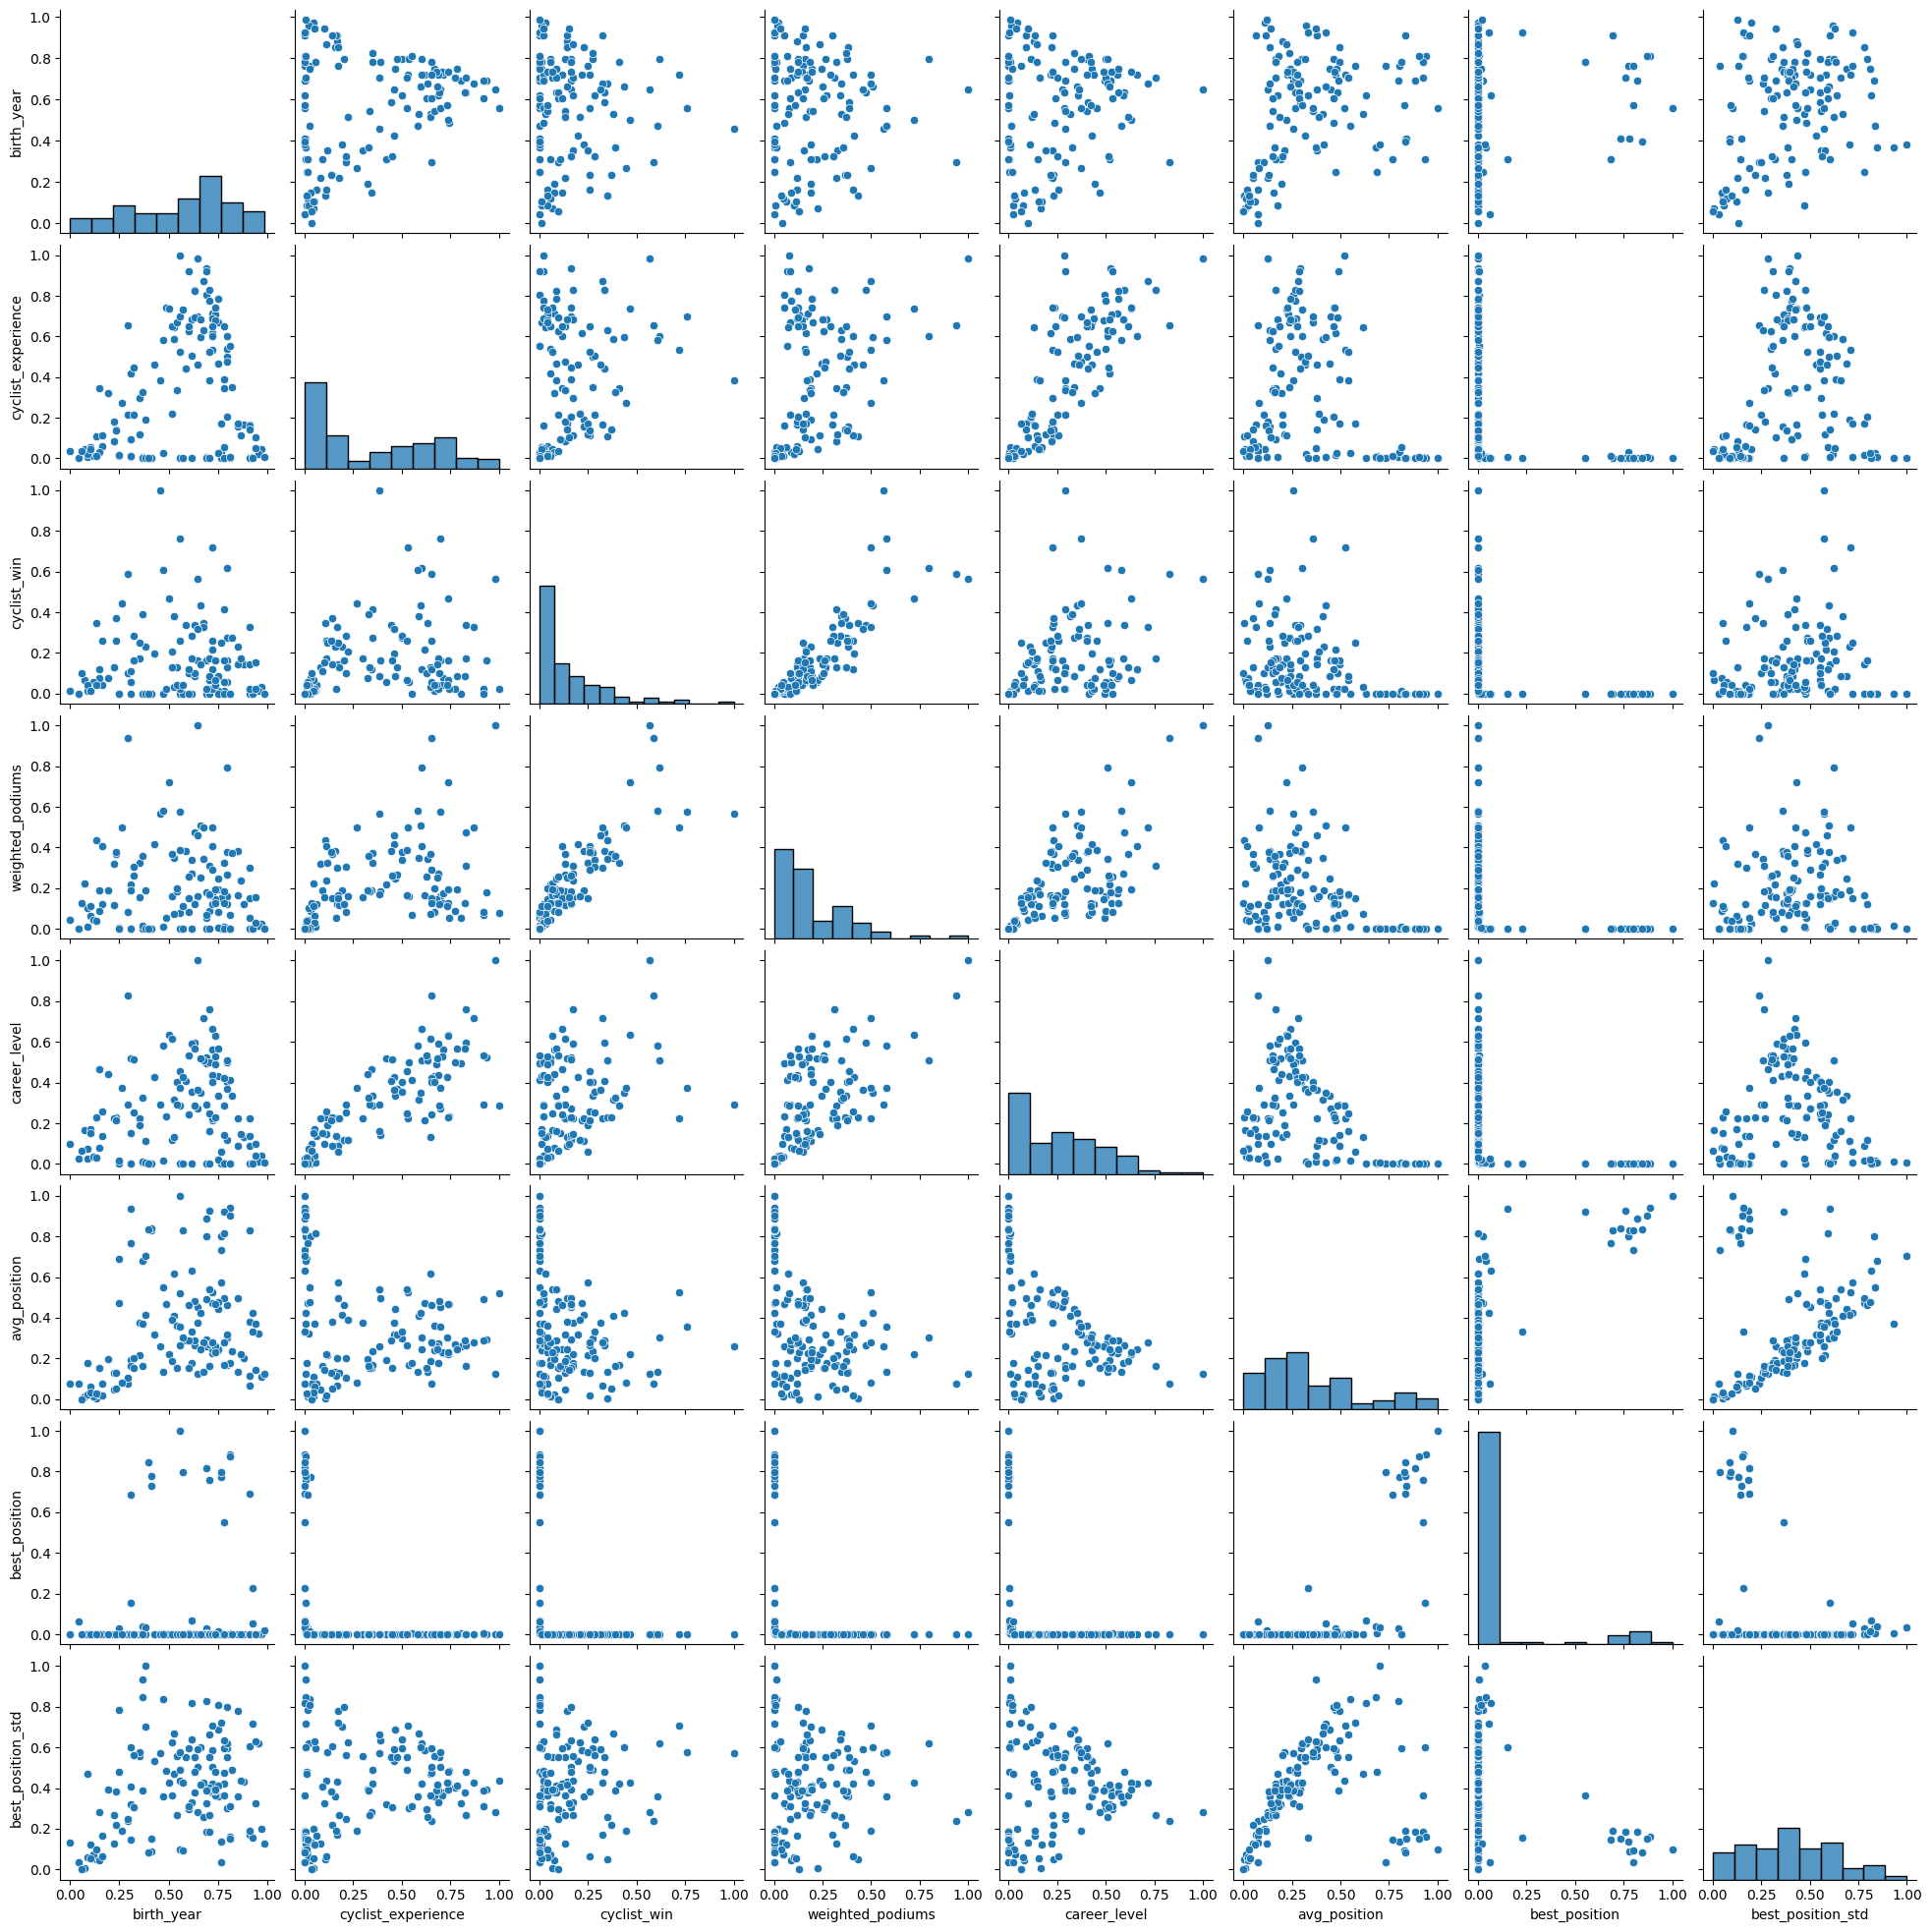

In [41]:
# Create a pairplot to visualize the relationships between features in the normalized outlier dataframe
sns.pairplot(normalized_outlier_df)
plt.show()

In [42]:
cyclists_with_outlier_score = cyclists_with_outlier_score[cyclists_with_outlier_score['all_outlier'] != 1]
cyclists_with_outlier_score.drop(columns=['connectivity_outlier', 'svm_outlier', 'isolation_forest_outlier' ,'all_outlier', 'lof_degree'], inplace=True)

In [43]:
cyclists_with_outlier_score.columns

Index(['_url', 'name', 'birth_year', 'nationality', 'cyclist_experience',
       'experience_cat', 'continent', 'cyclist_win', 'weighted_podiums',
       'career_level', 'avg_position', 'best_position', 'best_position_std'],
      dtype='object')

In [ ]:
cyclists_df.to_csv('dataset/cyclists_outlier.csv', index=False)